# Capstone Project

![academy_logo](assets\academy_logo.JFIF)

Project presented as partial requirement for obtaining the certification of Entry Level Data Scientist from **Lisbon Data Science Academy**.

## Introduction
Predicting the outocome of whether or not a random car is making contraband and consequently allowing police to search the car is a relevant issue. Especially, in the state of Connecticut which has been receiving a lot of complaints about its stop and search policy used by its law enforcement agencies. The complainers of this matter claim to exist a bias towards people with certain backgrounds.

The current literature about this topic in its majority attempts to...

To conclude the objective of such project is to determined if the existent complaints are factual or not, and provide service to which a police officer request authorization for searching a car. The service, will try predict if a car is actually smugling anything or not

# Imports

In [2]:
# Necessary Imports
import pandas as pd
import numpy as np
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas profiling to make an automatic study of all variables, may need to manually allow it in Anaconda
import pandas_profiling

# Web Scrapping 
import pandas as pd
import requests
import utils
from bs4 import BeautifulSoup

# Regular Expressions
import re

- create a map for the variable with the location
- Check the relationshio with the target variable

# 1- Understanding the data

The files we have available for the **training** stage are:
* `train.csv` has the bakcground of individuals that were pulled over during a police rodaside inspections and whether or not the car was searched

## Reading the Training Dataset

In [3]:
def read_data() -> pd.DataFrame:
    """Imports a dataset containing history of cars searched for contraband. 
                                    
    Returns
        data (pd.DataFrame): Represents the entire dataset, but it ensures that column names are lower case and that are no
                                 whitespaces in between the names
                             The dataframe holds values for:
                                Operation Details and Results (location of the intervention for example) for each car,
                                and the Background of a driver.
                  
    """
    path = os.path.join('data', 'train.csv')
    data = pd.read_csv(path)
    
    #Check with Caetano if this is necessary
    for name in data.columns:
        
        data = data.rename(columns={name:name.lower().replace(" ", "_")})
        
    return data

In [4]:
data = read_data()
data.head()

,vehiclesearchedindicator,contrabandindicator,department_name,interventiondatetime,interventionlocationname,interventionreasoncode,reportingofficeridentificationid,residentindicator,searchauthorizationcode,statutereason,subjectage,subjectethnicitycode,subjectracecode,subjectsexcode,townresidentindicator
0,False,False,New Haven,10/01/2013 12:00:00 AM,NEW HAVEN,V,262,True,N,Stop Sign,31.0,H,W,M,True
1,False,False,State Police,10/01/2013 12:00:00 AM,WILLINGTON,V,1000002715,False,N,Other,29.0,M,W,M,False
2,False,False,Plymouth,10/01/2013 12:00:00 AM,Terryville,V,21,True,N,Speed Related,18.0,N,W,M,True
3,False,False,Plymouth,10/01/2013 12:00:00 AM,Plymouth,V,D1,True,N,Speed Related,52.0,N,W,F,False
4,False,False,Bethel,10/01/2013 12:00:00 AM,BETHEL,V,08M,True,N,Cell Phone,34.0,N,W,M,False


## 1.1 - Creating Dataset Profile Before Feature Engineering & Data Cleaning 

In [5]:
# Generates a html with the characterization of all variables
profile = pandas_profiling.ProfileReport(data)
profile.to_file("data/data_train_profile_before_feature_engineering.html")

## 1.2 - Dataset Overview

### 1.2.1 - Dataset info

* `Number of variables`	15
* `Number of observations`	2473643
* `Total Missing (%)`	0.0%
* `Total size in memory`	217.0 MiB
* `Average record size in memory`	92.0 B

### 1.2.2 - Warnings

* `Department Name has a high cardinality:` 122 distinct values Warning
* `InterventionDateTime has a high cardinality:` 1450465 distinct values Warning
* `InterventionLocationName has a high cardinality:` 2505 distinct values Warning
* `ReportingOfficerIdentificationID has a high cardinality:` 8594 distinct values Warning


`Dataset has 204756 duplicate rows Warning`

In [5]:
def dropping_variables(df) -> pd.DataFrame:
    """ This function returns a dataframe. Each that has a higher amount than 60% of missing values
    is going to be dropped
    """
    data = df.copy()
    
    variables_to_drop = []
    
    for col in data.columns:
    
        null_count = data[col].isnull().sum()
        
        if null_count > 0.6*len(data):
            variables_to_drop.append(col)
            
    if variables_to_drop == []:
        return data
    else:
        return data.drop([variables_to_drop],axis=1)   

In [6]:
data = dropping_variables(data)

### Generic Functions

In [7]:
def replacing_missing_values(df) -> pd.DataFrame:
    """
    """
    data = df.copy()
    
    cols_with_missing_values = []
    col_names = data.columns.tolist()
    
    for col in col_names:
        if data[col].isnull().sum() == 0:
            pass
        else:
            cols_with_missing_values.append(col)
            
    for col in cols_with_missing_values:
        if data[col].dtype.name == 'object':
            data[col] = data[col].fillna(data[col].mode()[0])
        elif data[col].dtype.name == bool:
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            data[col] = data[col].fillna(data[col].median())
            
    return data

In [8]:
def lower_strip_case_dtype_object(df) -> pd.DataFrame:
    """ Returns a DataFrame in which all the object type variables have been converted to lower case 
    and the whitespaces on the edges have been removed.
    
    Args:
        df(pd.DataFrame): Original DataFrame 
        
    Returns:
        data(pd.DataFrame): Lower and Strip case DataFrame
    """
    data = df.copy()
    
    object_data = data.select_dtypes(include='object')
    object_data_columns = object_data.columns
    
    for col in object_data_columns:
        data[col] = data[col].str.lower().str.strip()
    
    return data

In [9]:
data = lower_strip_case_dtype_object(data)

### 1.2.3 - Types of Variables

Variables types

* `Numeric`	1
* `Categorical`	10
* `Boolean`	4
* `Date`	0
* `Text` (Unique)	0
* `Rejected`	0
* `Unsupported`	0

### 1.2.3.1 - Target Variable

![Target Variable](assets\target_variable_before_feature_engineering.png)

* The missing values in the target variable will be considered to be **False**. Therefore we have an extremely unbalanced dataset. Thus I will have to resort to techniques such as **UnderSampling** or **OverSampling**.

In [13]:
# percentage of true values
percentage_of_true_contraband = round(((data['contrabandindicator']==True).sum()/len(data))*100,2)
print('true values: ',percentage_of_true_contraband)
# percentage of False values
print('False: ', 100-percentage_of_true_contraband)

true values:  1.15
False:  98.85


### 1.2.3.2 - Department_Name 

* `Department Name has a high cardinality:` 122 distinct values Warning

* This dataset represent the police departments of the state of connecticut `Connecticut`

![Target Variable](assets\department_name_before_feature_engineering.png)

#### State and Local Law Enforcement Agencies

* `State Police`
* **State Police / Highway Patrol** – State police often perform police duties to include highway patrol and statewide investigations. Some states have only highway patrol with investigative functions covered by a separate entity such as a state bureau of investigation. State police assist local police with investigations and emergencies that extend beyond the resources and jurisdictional boundaries of the local agency.


* `Local Police & Deputy Sheriffs`
* **Local Police** includes municipal, county, tribal, and regional police that derive authority from the local governing body that created it. The primary purpose is to uphold the laws of the jurisdiction, provide patrol, and investigate local crimes.

* **Deputy Sheriffs** – Generally sheriff’s offices are granted authority by the state to enforce state law at the local county level. Deputies commonly run the local jail, serve warrants and court summons, and respond to calls for service in areas outside local police jurisdictions.
Law Enforcement Accr


* `CSP troops`
* The **Connecticut State Police (CSP)** is a division of the Connecticut Department of Emergency Services and Public Protection responsible for traffic regulation and law enforcement across the state of Connecticut, especially in areas not served by (or served by smaller) local police departments. The CSP currently has approximately 1,031 troopers, and is headquartered in Middletown, Connecticut. It is responsible for protecting the Governor of Connecticut, Lieutenant Governor of Connecticut, and their families.


* `Special Jurisdiction Police`
* **Special Jurisdiction Police** – Officers for special jurisdictions provide police services for defined entities or areas within another jurisdiction. These include parks, schools, transportation assets (e.g., airports, subways), hospitals, housing authorities, and government buildings. Special jurisdiction police are generally full-service departments, offering the same services as local police.

In [12]:
# In connecticut there are:
## 95 Distinct Police Departments
## 15 CST troops
## 11 Special Jurisdiction Police

def cleaning_department_name(df) -> pd.DataFrame:
    """ Returns a DataFrame with the variable department name corrected
    
    Args:
        df(pd.DataFrame): represents a dataframe where the variable department_name
                          as not been fixed yet
    Returns:
        data(pd.DataFrame): DataFrame with the variable department_name corrected
    """
    data = df.copy()
    
    # Converts all strings to lower case
    data['department_name'] = data['department_name'].str.lower()
    
    # Identifies the specific strings that have 3 or more words. Those were the only cases in which it 
    # was identified values with problems
    indexes_to_change = data[data['department_name'].apply(lambda x: len(x.split())) >= 3].index
    
    data.loc[indexes_to_change,'department_name'] = data.loc[indexes_to_change,'department_name']\
    .apply(lambda x: x.replace('police','').strip())
    
    data['department_name'] = data['department_name'].str.strip() 
    
    return data

In [13]:
data = cleaning_department_name(data)

### 1.2.3.3 - InterventionLocationName

![Target Variable](assets\intervention_location_name_before_feature_engineering.png)

* I will want to understand which variable add more value to the performance of the model, department_name or intervention locationname. Right now I'm thinking that one is basically the other, but in some IterventionLocationName is more specific in certain observations

#### Preparing a list to validate the locations of intervention

In [14]:
def interventionlocation_validation_list():
    """
    """
# Towns and Cities in Connecticut
    towns_cities_url = 'https://portal.ct.gov/Government/Cities-and-Towns'
    
    response_1 = requests.get(towns_cities_url)
    
    
    # Printing short output, if you want to see everything, delete the friendly_print function call
    soup_1 = BeautifulSoup(response_1.content, 'html.parser')
    
    towns_and_cities_info = str(soup_1.findAll('a','title', class_=False))
    
    pattern_1 = r'"\b[A-z][a-z]*\b \b[A-z][a-z]*\b"|"\b[A-z][a-z]*\b"'
    
    connecticut_towns_and_cities =\
    [n.strip('"') for n in re.findall(pattern_1, towns_and_cities_info)\
     if (n != '"noopener noreferrer"')& (n != '"_blank"')&(len(n)>3)][1:-1]
    
#census-designated places in Connecticut
    cdp_connecticut_url = 'https://en.wikipedia.org/wiki/List_of_census-designated_places_in_Connecticut'
    
    response_2 = requests.get(cdp_connecticut_url)
    
    # Printing short output, if you want to see everything, delete the friendly_print function call
    soup_2 = BeautifulSoup(response_2.content, 'html.parser')
    
    cdp_connecticut = str(soup_2.findAll('a','title', class_=False))
    
    pattern_2 = r'[title]{5}=(.*?,)'
    
    removing_special_characters = [re.sub('[",]', '', n) for n in re.findall(pattern_2, cdp_connecticut)[3:-85]]

    removing_county = [re.sub('[County]{6}', '', n) for n in removing_special_characters]

    removing_cdp_village =  np.unique([n.split('(')[0].strip() for n in removing_county]).tolist()

# Villages in connecticut 

    villages_connecticut_url = 'https://en.wikipedia.org/wiki/Category:Villages_in_Connecticut'

    response_3 = requests.get(villages_connecticut_url)

    # Printing short output, if you want to see everything, delete the friendly_print function call
    soup_3= BeautifulSoup(response_3.content, 'html.parser')

    villages_connecticut = str(soup_3.findAll('a','title', class_=False))
    
    pattern_2 = r'[title]{5}=(.*?,)'
    
    villages_list = [re.sub('[",]', '', n) for n in re.findall(pattern_2, cdp_connecticut)[5:-37]]
    
    location_1_word = []
    location_2_word = []
    location_3_word = []
    locations_more_than_3 = []
    
    for n in villages_list:
        if len(n.split()) == 1:
            location_1_word.append(n)
        elif len(n.split()) == 2:
            location_2_word.append(n)
        elif len(n.split()) == 3:
            location_3_word.append(n)
        elif len(n.split()) > 3:
            locations_more_than_3.append(n)
    
    location_2_word = [re.sub('[(CDP)]{5}', '', n) for n in location_2_word]
    
    locations_more_than_3_with_district = [x.split('District')[0]+'District'\
                                       for x in locations_more_than_3 if re.search('District', x)] 
    locations_more_than_3_no_district = [x.split('District')[0]+'District'\
                                       for x in locations_more_than_3 if not re.search('District', x)]
    locations_more_than_3_clean = \
    locations_more_than_3_with_district + [locations_more_than_3_no_district[0].split('>')[0]] +\
    [' '.join(locations_more_than_3_no_district[1].split()[:2])]
    
    villages_final_list = location_1_word+location_2_word+location_3_word+locations_more_than_3_clean
    
# Final list Output

    final_list = np.unique(connecticut_towns_and_cities + removing_cdp_village + villages_final_list).tolist()
    
    final_list = [n.lower() for n in final_list]
    
    return final_list

In [15]:
connecticut_towns_cities_cdp_villages = interventionlocation_validation_list()

In [16]:
# data['interventionlocationname'] = data['interventionlocationname'].replace('  ',' ').apply(lambda x: str(x).strip().lower())

#### Locations Validated

In [17]:
len(data[data['interventionlocationname'].isin(connecticut_towns_cities_cdp_villages)]['interventionlocationname'].unique())

194

In [18]:
round((len(data[data['interventionlocationname'].isin(connecticut_towns_cities_cdp_villages)]['interventionlocationname'])/(len(data)))*100,2)

98.83

#### Locations Not Validated

- They represent only 1.2% of the entire sample.

- For the locations that were not validated, it will be assigned the value `other`

In [19]:
round(((len(data)-len(data[data['interventionlocationname'].isin(connecticut_towns_cities_cdp_villages)]['interventionlocationname']))/len(data))*100,2)

1.17

In [20]:
def cleaning_interventionlocation(df) -> pd.DataFrame:
    """
    """
    
    data = df.copy()
    
    data['interventionlocationname'] = \
    data['interventionlocationname'].replace('  ',' ').apply(lambda x: str(x).strip().lower())
    
    index_to_change = data[~data['interventionlocationname'].isin(connecticut_towns_cities_cdp_villages)].index.tolist()
    
    data.loc[index_to_change,'interventionlocationname'] = 'other'
    
    return data

In [21]:
data = cleaning_interventionlocation(data)

- Reduced from 2505 distinct intervention locations to 195. One specific category is "Other", and it holds more than 1500 distinct categories.

### 1.2.3.4 - InterventionDatetime

![Target Variable](assets\intervention_datetime_before_feature_engineering.png)

* I have to convert this variable to datetime


* I have to sort the current dataframe from the oldest date to the most recent one.

In [22]:
def convert_to_datetime(df,n=100000) -> pd.DataFrame:  
    """Returns a sorted dataframe according to the dates in column interventiondatetime
    
    Args:
        df(pd.DataFrame): Original DataFrame, it's not a transformation in a chain.
        
        n(int): represents the number of observations that are taken into consideration when
                trying to detect the format of the datetime string
        
    Returns:
        data(pd.DataFrame): Sorted Dataframe according to the converted (to_datetime)
                            interventiondatetime variable
    """
    data = df.copy()
    
    # The objective of this list of different formats is an attempt to try to prevent the model 
    # when cleaning the dataset for which it will make the requested predictions.
    date_formats = ["%Y-%m-%d %H:%M:%S %p", "%d-%m-%Y %H:%M:%S %p", "%m-%d-%Y %H:%M:%S %p",
                    "%Y/%m/%d %H:%M:%S %p", "%d/%m/%Y %H:%M:%S %p", "%m/%d/%Y %H:%M:%S %p", 
                    "%Y.%m.%d %H:%M:%S %p", "%d.%m.%Y %H:%M:%S %p", "%m.%d.%Y %H:%M:%S %p"]
    
    # This function return a list of format(s) that can be used to transform the data
    # faster to date format. It is expeceted to return a single value in this list,
    # but it can it has more than 1, the output of the overall function will raise an 
    # error
    
    def string_to_date(df):
        match = []
        for fmt in date_formats:
            try:
                pd.to_datetime(df,format = fmt)
            except ValueError as e:
                continue
            match.append(fmt)
        return match
    
    correct_format = string_to_date(data['interventiondatetime'][:n])
    
    # Validation test
    if len(correct_format) != 1:
        raise ValueError('Argument n has to be bigger')
    else:
    # I have inserted the format of time, to me more efficient in terms of time. However, I have to ensure 
    # that this is the format for the unseen data 
        data['interventiondatetime'] = pd.to_datetime(data['interventiondatetime'],format = correct_format[0])
    
        data = data.sort_values(by=['interventiondatetime'])
    
        return data

In [23]:
data = convert_to_datetime(data)

### 1.2.3.5 - InterventionReasonCode

![Target Variable](assets\intervention_reason_code.png)

- Somthing is wrong in this variable. It's only supposed to have 3 unique categories:
    - `"Investigation:` - I
    - `Violation:` - V
    - `Equipment:` - E

In [24]:
def cleaning_interventionreasoncode(df) -> pd.DataFrame:
    """ This function has the purpose of ensuring that only [e,v,i] are represented in this variable,
        the remaining ones will assumed to be null values
        
    Args:
        df(pd.DataFrame): original data
        
    Return:
        data(pd.DataFrame): is the same as the dataframe inserted as an argument, the variable interventionreasoncode
        has been cleaned
    """
    
    data = df.copy()
    
    correct_values = ['v','e','i']
    
    data['interventionreasoncode'] = data['interventionreasoncode'].str.lower()
    
    data[~data['interventionreasoncode'].isin(correct_values)] = np.NaN
    
    return data   

In [25]:
# The values which the were being assumed as distinct categories were, 'NaN' and 'no'
cleaning_interventionreasoncode(data)['interventionreasoncode'].isnull().sum()

5

In [26]:
data = cleaning_interventionreasoncode(data)

### 1.2.3.6 - ReportingOfficerID 

![reporting_officer_id_before_feature_engineering](assets\reporting_officer_id_before_feature_engineering.png)

- There no codes with no more than 12 characters

In [27]:
data[data['reportingofficeridentificationid'].apply(lambda x: len(str(x))) >= 13]['reportingofficeridentificationid'].unique().tolist()

['1899-12-31t11:12:00',
 'prisoner transport',
 'west holdover',
 'south holdover',
 'east holdover',
 'north holdover']

In [28]:
def replace_wrong_reporting_officer_id(df):
    """ This function as the purpose of cleaning the variable reporting officer
    
    Args:
        df(pd.DataFrame): original data
        
    Return:
        data(pd.DataFrame): is the same as the dataframe inserted as an argument, the variable reportingofficerid
        has been cleaned
    """
    data = df.copy()
    
    index_to_change = data[data['reportingofficeridentificationid']\
         .apply(lambda x: len(str(x))) >= 13]['reportingofficeridentificationid'].index.tolist()
    
    index_to_change = index_to_change + data[data['reportingofficeridentificationid']\
                                             .apply(lambda x: type(x)==str) == False].index.tolist()
    
    data.loc[index_to_change,'reportingofficeridentificationid'] = np.NaN
    
    return data

In [29]:
data = replace_wrong_reporting_officer_id(data)

- **I do not what do exactly with this variable**.

### 1.2.3.7 - ResidentIndicator

![resident_id_before_feature_engineering](assets\resident_id_before_feature_engineering.png)

In [25]:
data['residentindicator'].unique()

array([ True, False])

- There is nothing wrong with this variable

### 1.2.3.8 - SearchAuthorizationCode

![search_authorization_code_feature_engineering](assets\search_authorization_code_feature_engineering.png)

* `N-Not Applicable`: Authorization code has not been provided


* C-`Consent` 


* I-`Inventory` 


* O-`Other`:Probable Cause,  Reasonable Suspicion,  Plain View Contraband,
    Incident to Arrest,  Drug Dog Alert, Exigent Circumstances"

In [37]:
data['searchauthorizationcode'].unique()

array(['n', 'o', 'i', 'c', nan], dtype=object)

In [40]:
(~data['searchauthorizationcode'].isin(['n','o','i','c'])).sum()

10

### 1.2.3.9 - StatusReason

![status_reason_before_feature_engineering](assets\status_reason_before_feature_engineering.png)

In [31]:
data['statutereason'].unique()
# I'm going to assume other/error to be only error

array(['speed related', 'window tint', 'display of plates', 'other',
       'defective lights', 'cell phone', 'traffic control signal',
       'equipment violation', 'moving violation', 'stop sign', 'seatbelt',
       'registration', 'suspended license', nan, 'other/error',
       'stc violation', 'administrative offense', 'unlicensed operation'],
      dtype=object)

In [32]:
def cleaning_status(df):
    """
    """
    data = df.copy()
    
    data[data['statutereason']=='other/error'] = 'error'
    
    return data

In [33]:
data = cleaning_status(data)

In [34]:
data['statutereason'].isnull().sum()

512

- The only problem of this variable appears to be with null values

### 1.2.3.10 - SubjectAge

![subject_age_before_feature_engineering](assets\subject_age_before_feature_engineering.png)

* In the state of Conneticut is possible to start driving at the age of 16 with a Learner's Permit or a Restricted Permit. The full licence can only be obtained at the age of 18.


* License Renewal Rules for Older Drivers 


    * Drivers age 65 and older must renew in person every two years; those younger need to renew every six years. Individuals with a major medical condition may submit a request for license renewal by mail; they must first contact the DMV at 860-263-5148 and ask for a review of their situation.
    
        *  common restrictions include:
            *  no nighttime driving
            *  no freeway driving
            *  driving only vehicles with automatic transmission
            *  driving a vehicle with an additional external mirrors
            *  driver must wear hearing aid, and special controls or equipment in the vehicle.

(array([444.,  60., 128.,  32.,   6.,  34.,  40.,  33.,  29., 371.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <a list of 10 Patch objects>)

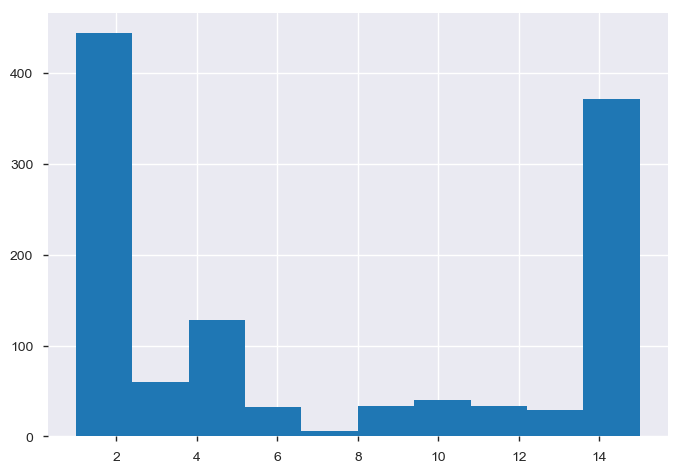

In [76]:
plt.hist(data[data['subjectage'] <= 15]['subjectage'])

In [42]:
(data['subjectage']<14).sum()

806

In [41]:
round(((data['subjectage']<14).sum()/len(data))*100,2)

0.03

In [83]:
def cleaning_subject_age(df) -> pd.DataFrame:
    """
    """
    
    data = df.copy()
    
    index_to_change = data[data['subjectage'] < 14].index.tolist()
    
    data.loc[index_to_change,'subjectage'] = data['subjectage'].median()
    
    return data

In [81]:
data = cleaning_subject_age(data,14)
# By applying the minimum age of 14 we are loosing 811 observations

(array([348292., 583215., 467336., 361864., 370873., 201083.,  99149.,
         30327.,   9559.,   1945.]),
 array([14. , 22.5, 31. , 39.5, 48. , 56.5, 65. , 73.5, 82. , 90.5, 99. ]),
 <a list of 10 Patch objects>)

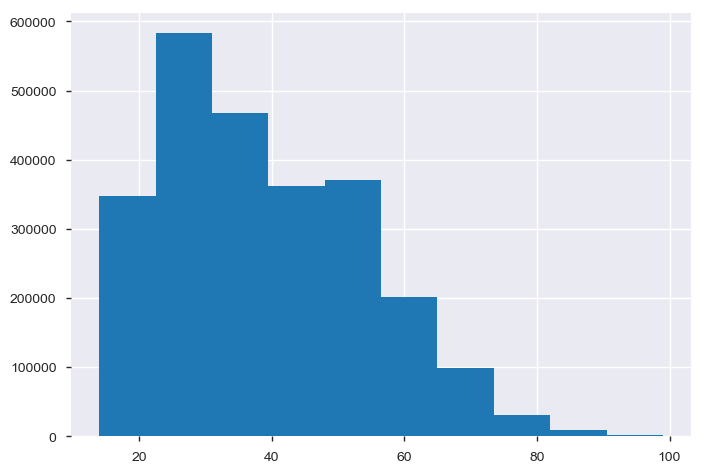

In [82]:
plt.hist(data['subjectage'])

### 1.2.3.11 - Ethinicity

![subject_ethinicity_code_before_feature_egineering](assets\subject_ethinicity_code_before_feature_egineering.png)

- For ethical reason I will try not to use this variable

In [32]:
data['subjectethnicitycode'].unique()

array(['h', 'm', 'n'], dtype=object)

### 1.2.3.12 - RaceCode

![subject_race_code_before_feature_engineering](assets\subject_race_code_before_feature_engineering.png)


- For ethical reason I will try not to use this variable

In [33]:
data['subjectracecode'].unique()

array(['w', 'b', 'a', 'i'], dtype=object)

- All individuals race has been identified there are no unkown values which fall under the U category.

### 1.2.3.13 - SexCode

![subject_sex_code_before_feature_egineering](assets\subject_sex_code_before_feature_egineering.png)


- For ethical reason I will try not to use this variable

In [26]:
data['subjectsexcode'].unique()

array(['m', 'f'], dtype=object)

In [35]:
data['subjectsexcode'].isnull().sum()

0

### 1.2.3.14 - TownResidentIndicator

![town_resident_indicator_before_feature_engineering](assets\town_resident_indicator_before_feature_engineering.png)


- It appears that there no exist any problems with the variable 

In [27]:
data['townresidentindicator'].unique()

array([ True, False])

In [28]:
data['townresidentindicator'].isnull().sum()

0

### 1.2.3.15 - SearchVehicleIndicator

![vehicle_search_indicator_before_feature_engineering](assets\vehicle_search_indicator_before_feature_engineering.png)

- It appears that there no exist any problems with the variable 

In [29]:
data['vehiclesearchedindicator'].unique()

array([False,  True])

In [30]:
data['vehiclesearchedindicator'].isnull().sum()

0